In [1]:
import os
import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.distributions as dist

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal

from IPython.display import Image

from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.optim import optimize_acqf
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler
import warnings

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
force_cpu = True
if not force_cpu:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Using device", device)

Using device cpu


In [4]:
# try:
#     from google.colab import drive
#     drive.mount('/content/drive')
#     root = '/content/drive/MyDrive/Colab Notebooks'
# except:
root = '.'

fig_folder = f"{root}/figures"
backup_folder = f"{root}/backup"

os.listdir(root)
for f in fig_folder, backup_folder:
    os.makedirs(f, exist_ok=True)

print("Backup folder:", backup_folder)
print("Figures folder:", fig_folder)

Backup folder: ./backup
Figures folder: ./figures


# CartPole env: Demo

## CartPole env

In [5]:
import gymnasium as gym
env = gym.make('CartPole-v1')

for _ in range(10):
    observation, info = env.reset(seed=0)
    # print(observation)
    t = 0
    terminated, truncated = False, False
    while not terminated and not truncated:
        action = env.action_space.sample()  # agent policy that uses the observation and info
        observation, reward, terminated, truncated, info = env.step(action)
        t += 1
        
env.close()

# Using reinforce

In [6]:
def eval_trajectory(env, trajectory):
    
    observation, info = env.reset(seed=0)
    t = 0
    terminated, truncated = False, False
    while not terminated and not truncated:
        try:
            action = trajectory[t]
            # action = env.action_space.sample()  # agent policy that uses the observation and info
            observation, reward, terminated, truncated, info = env.step(action)
            t += 1
        except IndexError:
            break
    return t


def eval_policy(env, policy, p=None, kl_div_factor=0.001, n_sample=10):
    
    q = dist.Binomial(probs=policy)
    trajectories = q.sample((n_sample, ))
    
    loss, p_sum = 0, 0

    for traj in trajectories:

        reward = eval_trajectory(trajectory=traj.long().cpu().numpy(), env=env)

        p_traj = q.log_prob(traj).sum().exp()
        loss -= p_traj * reward
        p_sum += p_traj

    loss /= p_sum
    
    if p is not None:
        kl_div = dist.kl_divergence(q, p).sum()
        loss += kl_div_factor * kl_div
    
    return loss/len(policy)

In [7]:
n_steps = 50
epochs = 500 

param = nn.Parameter(torch.zeros(n_steps))
optimizer = optim.Adam([param, ], lr=0.2)

n_sample = 10

p = dist.Binomial(probs=torch.ones(n_steps)*0.5)

with tqdm(total=epochs) as pbar:
    for epoch in range(1, epochs + 1):
        
        optimizer.zero_grad()
        
        loss = eval_policy(env=env, policy=torch.sigmoid(param), p=p)

        loss.backward()
        optimizer.step()

        pbar.update()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        

  0%|          | 0/500 [00:00<?, ?it/s]

In [8]:
n_sample = 1000
sum_reward = 0
with torch.no_grad():
    q = dist.Binomial(probs=torch.sigmoid(param))
    trajectories = q.sample((n_sample, ))
    for traj in trajectories:

        reward = eval_trajectory(trajectory=traj.long().numpy(), env=env)
        sum_reward += reward
print("After training", sum_reward/n_sample)

n_sample = 10000
sum_reward = 0
with torch.no_grad():
    q = dist.Binomial(probs=torch.sigmoid(torch.zeros(n_steps)))
    trajectories = q.sample((n_sample, ))
    for traj in trajectories:
        reward = eval_trajectory(trajectory=traj.long().numpy(), env=env)
        sum_reward += reward
print("Random", sum_reward/n_sample)

After training 43.477
Random 21.2448


In [9]:
with torch.no_grad():
    reward =  - eval_policy(env=env, policy=torch.sigmoid(param), n_sample=1000)
    print("After training", reward)
    reward = - eval_policy(env=env, policy=torch.sigmoid(torch.zeros(n_steps)), n_sample=1000)
    print("Random", reward)

After training tensor(0.9955)
Random tensor(0.4215)


# VAE/Regression + GP

## Vae model

In [10]:
class VAE(nn.Module):
    def __init__(self, size_z):
        super().__init__()

        self.enc1 = nn.Linear(n_steps, 40)
        self.enc2 = nn.Linear(40, 20)
        self.mu = nn.Linear(20, size_z)
        self.logvar = nn.Linear(20, size_z)
        
        self.dec1 = nn.Linear(size_z, 20)
        self.dec2 = nn.Linear(20, 40)
        self.dec3 = nn.Linear(40, n_steps)

    def encode(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = F.relu(self.dec1(z))
        z = F.relu(self.dec2(z))
        x = torch.sigmoid(self.dec3(z))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Vae loss

In [11]:
# Reconstruction + KL divergence losses summed over all elements and batch
def vae_loss(recon_x, x, mu, logvar):
    bce = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    
    return bce + kl

## Regression Model

In [12]:
class Regression(nn.Module):
    def __init__(self, size_z):
        super().__init__()
        self.pred1 = nn.Linear(size_z, size_z*2)
        self.pred2 = nn.Linear(size_z*2, size_z)
        self.pred3 = nn.Linear(size_z, 1)

    def forward(self, x):
        x = F.relu(self.pred1(x))
        x = F.relu(self.pred2(x))
        x = self.pred3(x).squeeze()     
        return x

## Regression loss

In [13]:
def regression_loss(pred, y):
    # assert pred.shape == y.shape
    loss = nn.MSELoss(reduction="sum")
    # output = loss(pred.squeeze(), y.float())
    return loss(pred, y)

## Fit VAE

In [14]:
def fit_vae(
        vae, reg, train_x, train_y, 
        learning_rate=0.1,
        batch_size=64,
        epochs=200,
        weight_reg_loss=10e4):
    
    class TrainDataset(Dataset): 
        def __init__(self):
            super().__init__()
        def __len__(self):
            return len(train_y)
        def __getitem__(self, idx):
            return train_x[idx], train_y[idx]
        
    train_loader = DataLoader(TrainDataset(), batch_size=batch_size)
    
    vae.train()
    reg.train()

    optimizer = optim.Adam(list(vae.parameters()) + list(reg.parameters()), lr=learning_rate)
    
    with tqdm(total=epochs, leave=False) as pbar:
        
        for epoch in range(1, epochs + 1):
            
            train_vae_loss, train_reg_loss = 0, 0
                        
            for batch_idx, (x, y) in enumerate(train_loader):

                x, y = train_x, train_y
                x = x.to(device)
                y = y.to(device)

                optimizer.zero_grad()

                recon_x, mu, logvar = vae(x)
                l_vae = vae_loss(recon_x=recon_x, x=x, mu=mu, logvar=logvar)

                pred = reg(mu)
                l_reg = weight_reg_loss*regression_loss(y=y, pred=pred)

                loss = l_vae + l_reg
                loss.backward()
                optimizer.step()

                train_vae_loss += l_vae.item()
                train_reg_loss += l_reg.item()
                    
            pbar.update()
            pbar.set_postfix({
                "loss VAE": f"{train_vae_loss/len(train_y):.4f}",
                "loss classifier": f"{train_reg_loss/len(train_y):.4f}"
            })

# Using GP on top of the things

In [15]:
# seed=1
# torch.manual_seed(seed)

size_z = 10

dtype=torch.float

vae = VAE(size_z).to(device)
reg = Regression(size_z).to(device)

SMOKE_TEST = False

acq_opt__batch_size = 3
acq_opt__num_restarts = 10
acq_opt__raw_samples = 256

qmc_sampler__sample_shape = 2048
qmc_sampler__seed = 123

n_batch = 300

n_sample_start = 15

max_n = 100

weight_reg_loss = 10000.


bkp_vae =     "vae_close_loop-gym__vae.p"
bkp_reg =     "vae_close_loop-gym__reg.p"
bkp_train_z = "vae_close_loop-gym__train_z.p"
bkp_gp =      "vae_close_loop-gym__gp.p"

if False:
    vae.load_state_dict(torch.load(bkp_vae))
    reg.load_state_dict(torch.load(bkp_reg))
    train_z = torch.load(bkp_train_z)

else:

    warnings.simplefilter("ignore")

    best_observed = []

    # --------------------------------
    train_z = torch.rand(n_sample_start, size_z, device=device, dtype=dtype)

    with torch.no_grad():
        train_x = vae.decode(train_z)
        train_y = torch.tensor([
            - eval_policy(
                env=env,
                policy=pol) for pol in train_x])  
    # ------------------------------


    state_dict = None
    # run N_BATCH rounds of BayesOpt after the initial random batch
    with tqdm(total=n_batch) as pbar:
        for iteration in range(n_batch):

            if len(train_x) > max_n:
                best = torch.topk(train_y, k=max_n).indices
                train_x = train_x[best]
                train_y = train_y[best]
                train_z = train_z[best]

            # Fit the VAE
            fit_vae(
                vae=vae, 
                reg=reg,
                train_x=train_x, 
                train_y=train_y, 
                weight_reg_loss=weight_reg_loss)

            with torch.no_grad():
                
                mu, logvar = vae.encode(train_x)
                train_z = vae.reparameterize(mu, logvar)

            # fit the GP model
            # normalize(train_h, bounds=bounds), 
            # standardize(train_obj) 
            model = SingleTaskGP(train_X=train_z, train_Y=train_y.unsqueeze(dim=1))
            # if state_dict is not None:
            #     model.load_state_dict(state_dict)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            mll.to(device)
            fit_gpytorch_mll(mll)

            # define the qNEI acquisition module using a QMC sampler
            qmc_sampler = SobolQMCNormalSampler(
                sample_shape=qmc_sampler__sample_shape,
                seed=qmc_sampler__seed
            )
            qEI = qExpectedImprovement(
                model=model, 
                sampler=qmc_sampler, 
                best_f=train_y.max())

            # optimize and get new observation
            # optimize
            bounds = torch.zeros((2, size_z))
            bounds[0, :] = - 10
            bounds[1, :] = 10
            candidates, _ = optimize_acqf(
                acq_function=qEI,
                bounds=bounds,
                q=acq_opt__batch_size,
                num_restarts=acq_opt__num_restarts,
                raw_samples=acq_opt__raw_samples,
            )

            # observe new values 
            with torch.no_grad():
                new_z = candidates.detach()
                new_x = vae.decode(new_z)
                new_y = torch.tensor([
                    - eval_policy(
                        env=env,
                        policy=pol) for pol in new_x])  

            # update training points
            train_z = torch.cat((train_z, new_z))
            train_x = torch.cat((train_x, new_x))
            train_y = torch.cat((train_y, new_y))

            # update progress
            best_value = train_y.max().item()
            best_observed.append(best_value)

            # state_dict = model.state_dict()
            
            pbar.update()
            pbar.set_postfix({"best": f"{best_value:.2f}"})

    torch.save(vae.state_dict(), bkp_vae)
    torch.save(reg.state_dict(), bkp_reg)
    # torch.save(model.state_dict(), bkp_gp)
    # torch.save(classifier_latent2digit.state_dict(), bkp_cls_latent2digit)
    torch.save(train_z, bkp_train_z)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Without GP

In [19]:
class DecisionMaker(nn.Module):
    def __init__(self, size_z):
        super().__init__()
        self.param = nn.Parameter(torch.rand(size_z))


class TrainDataset(Dataset): 
    def __init__(self, train_x, train_y):
        self.train_x = train_x
        self.train_y = train_y
        super().__init__()
    def __len__(self):
        return len(self.train_y)
    def __getitem__(self, idx):
        return self.train_x[idx], self.train_y[idx]


torch.autograd.set_detect_anomaly(True)

# seed=1
# torch.manual_seed(seed)

size_z = 25

dtype=torch.float

vae = VAE(size_z).to(device)
reg = Regression(size_z).to(device)

dm = DecisionMaker(size_z).to(device)

max_n = 500

policy_learning_rate = 1.0

vae_learning_rate = 0.1

n_epoch_vae = 50
batch_size_vae = 64
weight_reg_loss = 10000  

n_sample_start = 1000

n_sample_policy = 100


best_observed = []

# --------------------------------

print("creating samples")
train_z = torch.rand(n_sample_start, size_z, device=device, dtype=dtype)

with torch.no_grad():
    train_x = vae.decode(train_z)
    train_y = torch.tensor([
        - eval_policy(
            env=env,
            policy=pol) for pol in train_x]).to(device)

# ------------------------------

print("starting optimization")

state_dict = None
# run N_BATCH rounds of BayesOpt after the initial random batch
with tqdm(total=n_batch) as pbar:
    for iteration in range(n_batch):

        # ----------------
        # Cut the dataset 
        # ----------------
        if len(train_x) > max_n:
            best = torch.topk(train_y, k=max_n).indices
            train_x = train_x[best]
            train_y = train_y[best]
            train_z = train_z[best]

        train_loader = DataLoader(TrainDataset(train_x=train_x, train_y=train_y), batch_size=batch_size_vae)

        vae.train()
        reg.train()
    
        optimizer_vae = optim.Adam(list(vae.parameters()) + list(reg.parameters()), lr=vae_learning_rate)
        
        with tqdm(total=n_epoch_vae, leave=False) as pbar_vae:
            
            for epoch in range(n_epoch_vae):
                
                train_vae_loss, train_reg_loss = 0, 0
                            
                for batch_idx, (x, y) in enumerate(train_loader):
    
                    optimizer_vae.zero_grad()
    
                    recon_x, mu, logvar = vae(x)
                    bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
                    # see Appendix B from VAE paper:
                    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
                    # https://arxiv.org/abs/1312.6114
                    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
                    kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
                    l_vae = bce + kl
    
                    pred = reg(mu)
                    l_reg = weight_reg_loss*nn.MSELoss(reduction="sum")(target=y, input=pred)
    
                    loss = l_vae + l_reg
                    loss.backward()
                    optimizer_vae.step()
    
                    train_vae_loss += l_vae.item()
                    train_reg_loss += l_reg.item()

                pbar_vae.update()
                pbar_vae.set_postfix({
                    "loss VAE": f"{train_vae_loss/len(train_y):.4f}",
                    "loss regression": f"{train_reg_loss/len(train_y):.4f}"
                })

        # -------------------- 
        # Recompute train z
        # -------------------

        with torch.no_grad():
            
            mu, logvar = vae.encode(train_x)
            train_z = vae.reparameterize(mu, logvar)

        # --------------
        # Train policy
        # --------------   
        for child in model.children():
           if hasattr(child, 'reset_parameters'):
               child.reset_parameters()
        optimizer_policy = optim.Adam(dm.parameters(), lr=policy_learning_rate)
        with tqdm(total=n_sample_policy, leave=False) as policy_pbar:
            for smp in range(n_sample_policy):

                optimizer_policy.zero_grad()
                
                z = dm.param
                # print(dm.param)
                x = vae.decode(z)
                # print(new.requ)
                y = eval_policy(env=env, policy=x).to(device)
                loss = y
    
                loss.backward()
                optimizer_policy.step()
    
                # update training points
                train_z = torch.cat((train_z, z.unsqueeze(dim=0))).detach()
                train_x = torch.cat((train_x, x.unsqueeze(dim=0))).detach()
                train_y = torch.cat((train_y, y.unsqueeze(dim=0))).detach()

                policy_pbar.update()
                policy_pbar.set_postfix(loss=f"{loss.item():.4f}")

        # ------------

        # update progress
        best_value = train_y.max().item()
        best_observed.append(best_value)

        # state_dict = model.state_dict()
        
        pbar.update()
        pbar.set_postfix(best=f"{best_value:.2f}")

    # torch.save(vae.state_dict(), bkp_vae)
    # torch.save(reg.state_dict(), bkp_reg)
    # torch.save(model.state_dict(), bkp_gp)
    # torch.save(classifier_latent2digit.state_dict(), bkp_cls_latent2digit)
    # torch.save(train_z, bkp_train_z)

creating samples
starting optimization


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Tests

## Test regression network

In [ ]:
size_z = 2

class Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.pred1 = nn.Linear(size_z, size_z*2)
        self.pred2 = nn.Linear(size_z*2, size_z)
        self.pred3 = nn.Linear(size_z, 1)

    def forward(self, x):
        x = F.relu(self.pred1(x))
        x = F.relu(self.pred2(x))
        x = self.pred3(x).squeeze()     
        return x

def regression_loss(pred, y):
    loss = nn.MSELoss(reduction="mean")
    return loss(pred, y)

reg = Regression()
reg.to(device)
reg.train()

epochs= 5000
n = 2000

torch.manual_seed(123)
x = torch.randn((n, size_z))
# x = torch.randn((n, size_z-1))
# x = torch.hstack([x, torch.ones((n, 1))])

y = (2129393 + 2.423*x - 3.3*x**2).sum(dim=1)
y = (y - y.mean()) / y.std()

x = x.to(device)
y = y.to(device)

optimizer = optim.Adam(reg.parameters(), lr=0.1)

with tqdm(total=epochs) as pbar:
    
    for epoch in range(epochs):
      
        optimizer.zero_grad()
      
        pred = reg(x)
        loss = regression_loss(y=y, pred=pred)
      
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
          pbar.update(1000)
          pbar.set_postfix(loss=f"{loss.item():.4f}")
        

In [ ]:
x = torch.randn((3, 2))

print(torch.hstack([x, torch.ones((3, 1))]))

In [ ]:
print(x.mean(), x.std(), x.min(), x.max())
print(y.mean(), y.std(), y.min(), y.max())

## Test gradient

In [ ]:
optimizer = optim.Adam(nn.Parameter(torch.zeros(3.)), lr=0.1)

for epoch in range(100):
    
    optimizer.zer()

    optimloss = 
    
    optimiz.step()
    

## Test policy gradient

In [ ]:
class DecisionMaker(nn.Module):
    def __init__(self, size_z):
        super().__init__()
        self.param = nn.Parameter(torch.zeros(size_z))


size_z = n_steps
dm = DecisionMaker(size_z).to(device)
with torch.no_grad():
    z = dm.param
    x = torch.sigmoid(z)
    y = eval_policy(env=env, policy=x).to(device)
print(f"Eval start: {y.item():.4f}")

learning_rate = 0.2

n_epoch = 500

p = dist.Binomial(probs=torch.ones(n_steps).to(device)*0.5)
optimizer = optim.Adam(dm.parameters(), lr=learning_rate)

state_dict = None

hist_y = []

with tqdm(total=n_epoch) as pbar:
    for _ in range(n_epoch):

        optimizer.zero_grad()
        
        z = dm.param
        x = torch.sigmoid(z)
        loss = eval_policy(env=env, policy=x, p=p).to(device)
        y = - loss
        
        loss.backward()
        optimizer.step()

        hist_y.append(y.detach().item())
        best_value = np.max(hist_y) 
        
        pbar.update()
        pbar.set_postfix(loss=f"{loss.item():.4f}", best=f"{best_value:.4f}")

## Test VAE

In [78]:
class TrainDataset(Dataset): 
    def __init__(self, train_x, train_y):
        self.train_x = train_x
        self.train_y = train_y
        super().__init__()
    def __len__(self):
        return len(self.train_y)
    def __getitem__(self, idx):
        return self.train_x[idx], self.train_y[idx]


torch.autograd.set_detect_anomaly(True)

torch.manual_seed(1234)


n_sample_start = 2000
n_steps = 50

print("creating samples")
train_x = torch.rand(n_sample_start, n_steps).to(device)

with torch.no_grad():
    train_y = torch.tensor([
        - eval_policy(
            env=env,
            policy=pol) for pol in train_x]).to(device)

train_dataset = TrainDataset(train_x=train_x, train_y=train_y)

creating samples


In [79]:
import seaborn as sns

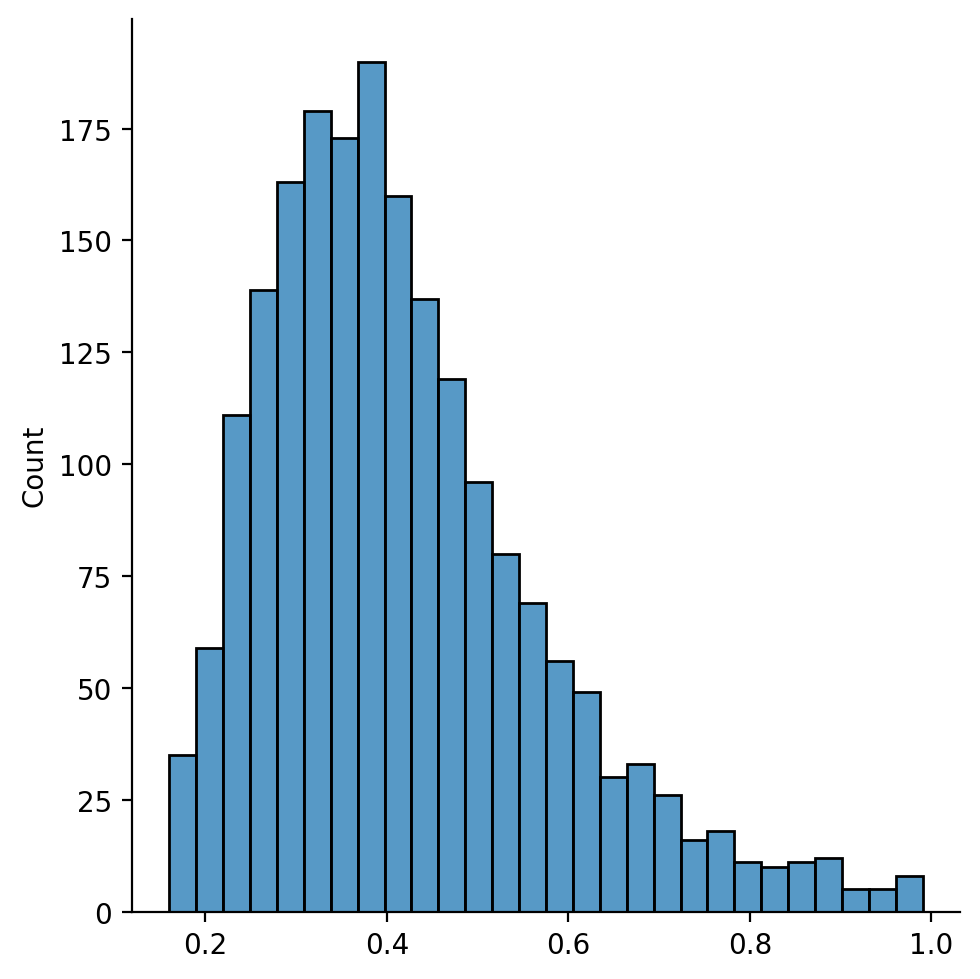

In [81]:
sns.displot(train_dataset.train_y)

In [88]:
class VAE(nn.Module):
    def __init__(self, n_steps, size_z):
        super().__init__()

        self.enc1 = nn.Linear(n_steps, 40)
        self.enc2 = nn.Linear(40, 20)
        self.mu = nn.Linear(20, size_z)
        self.logvar = nn.Linear(20, size_z)
        
        self.dec1 = nn.Linear(size_z, 20)
        self.dec2 = nn.Linear(20, 40)
        self.dec3 = nn.Linear(40, n_steps)

    def encode(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = F.relu(self.dec1(z))
        z = F.relu(self.dec2(z))
        x = torch.sigmoid(self.dec3(z))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class Regression(nn.Module):
    def __init__(self, size_z):
        super().__init__()
        self.pred1 = nn.Linear(size_z, size_z*2)
        self.pred2 = nn.Linear(size_z*2, size_z)
        self.pred3 = nn.Linear(size_z, 1)

    def forward(self, x):
        x = F.relu(self.pred1(x))
        x = F.relu(self.pred2(x))
        x = torch.sigmoid(self.pred3(x).squeeze())     
        return x

In [107]:
size_z = 2

vae = VAE(n_steps=n_steps, size_z=size_z).to(device)
reg = Regression(size_z).to(device)

vae_learning_rate = 0.001

n_epoch_vae = 1000
batch_size_vae = 200
weight_reg_loss = 10000  

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size_vae)

optimizer_vae = optim.Adam(list(vae.parameters()) + list(reg.parameters()), lr=vae_learning_rate)

with tqdm(total=n_epoch_vae, leave=True) as pbar_vae:
    
    for epoch in range(n_epoch_vae):
        
        train_vae_loss, train_reg_loss = 0, 0
                    
        for batch_idx, (x, y) in enumerate(train_loader):

            optimizer_vae.zero_grad()

            recon_x, mu, logvar = vae(x)
            bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
            # see Appendix B from VAE paper:
            # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
            # https://arxiv.org/abs/1312.6114
            # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
            kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
            l_vae = bce + kl

            pred = reg(mu)
            l_reg = weight_reg_loss*nn.MSELoss(reduction="sum")(target=y, input=pred)

            loss = l_vae + l_reg
            
            loss.backward()
            optimizer_vae.step()

            train_vae_loss += l_vae.item()
            train_reg_loss += l_reg.item()

        pbar_vae.update()
        pbar_vae.set_postfix({
            "loss VAE": f"{train_vae_loss/len(train_y):.4f}",
            "loss regression": f"{train_reg_loss/len(train_y):.4f}"
        })


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/1000 [00:00<?, ?it/s]

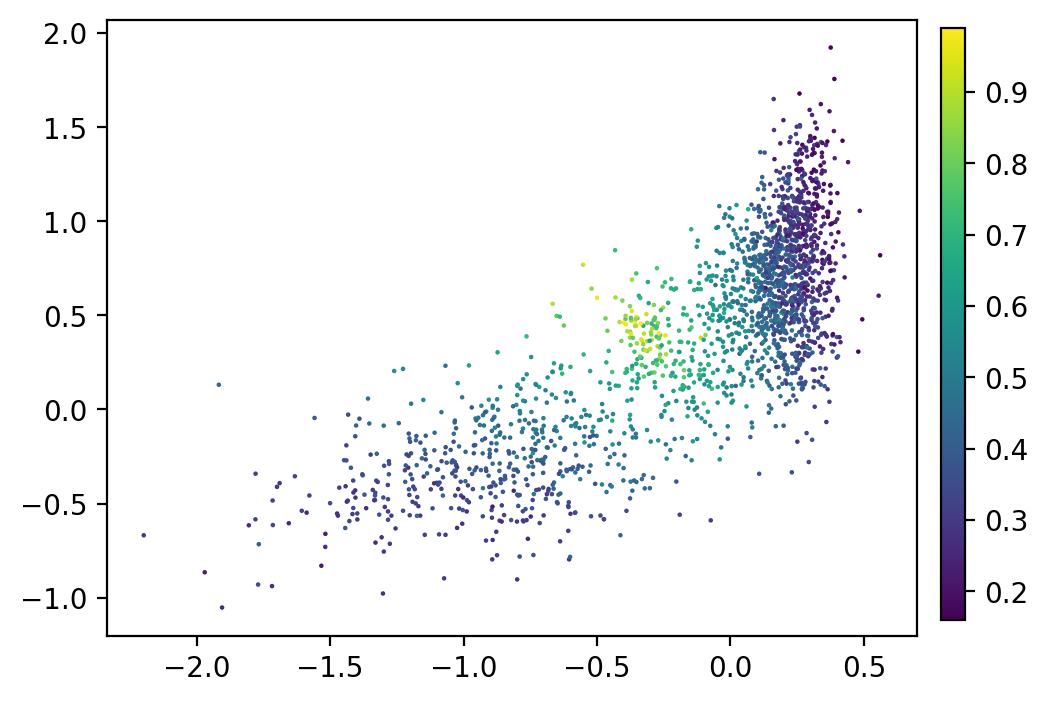

In [109]:
vae.eval()
x, y = train_dataset.train_x, train_dataset.train_y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 4))

im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=0.4)
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)

fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]))
plt.show()

## Test with GP train separately

In [122]:
class TrainDataset(Dataset): 
    def __init__(self, train_x, train_y):
        self.train_x = train_x
        self.train_y = train_y
        super().__init__()
    def __len__(self):
        return len(self.train_y)
    def __getitem__(self, idx):
        return self.train_x[idx], self.train_y[idx]


torch.autograd.set_detect_anomaly(True)

torch.manual_seed(1234)


n_sample_start = 300
n_steps = 50

print("creating samples")
train_x = torch.rand(n_sample_start, n_steps).to(device)

with torch.no_grad():
    train_y = torch.tensor([
        - eval_policy(
            env=env,
            policy=pol) for pol in train_x]).to(device)

train_dataset = TrainDataset(train_x=train_x, train_y=train_y)

creating samples


In [123]:
import seaborn as sns

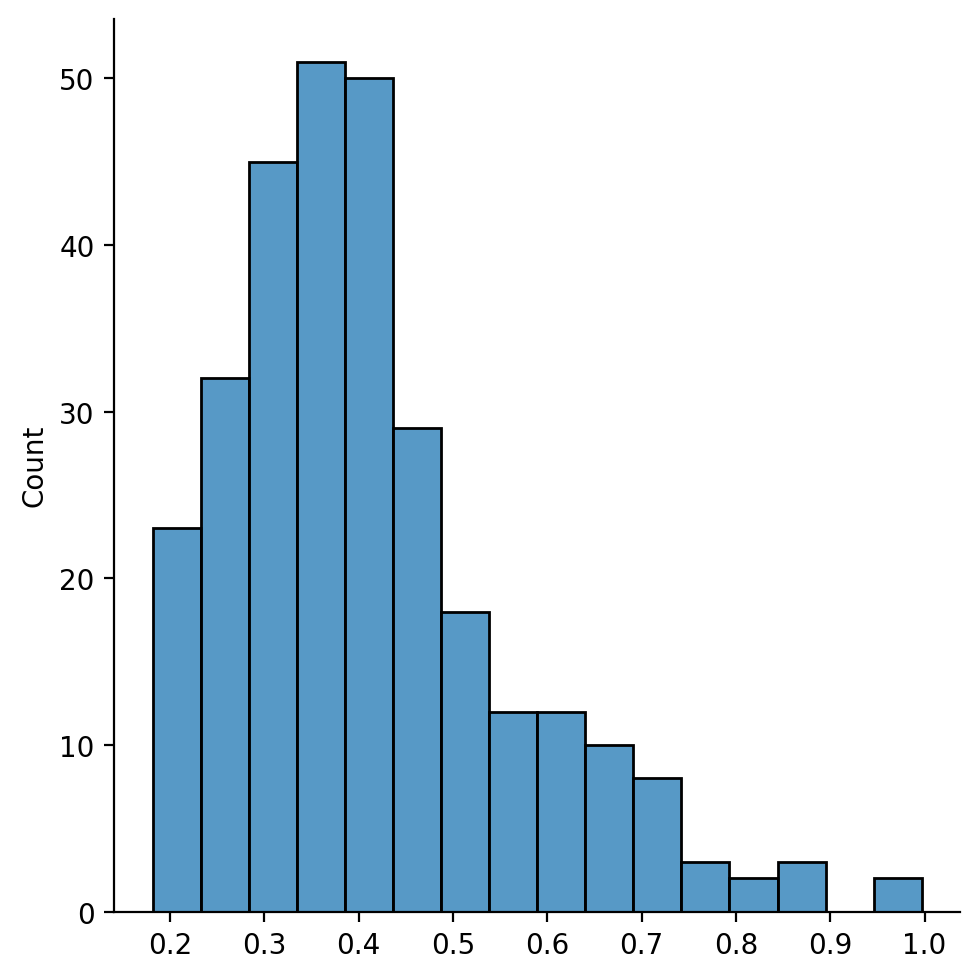

In [124]:
sns.displot(train_dataset.train_y)

In [125]:
class VAE(nn.Module):
    def __init__(self, n_steps, size_z):
        super().__init__()

        self.enc1 = nn.Linear(n_steps, 40)
        self.enc2 = nn.Linear(40, 20)
        self.mu = nn.Linear(20, size_z)
        self.logvar = nn.Linear(20, size_z)
        
        self.dec1 = nn.Linear(size_z, 20)
        self.dec2 = nn.Linear(20, 40)
        self.dec3 = nn.Linear(40, n_steps)

    def encode(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = F.relu(self.dec1(z))
        z = F.relu(self.dec2(z))
        x = torch.sigmoid(self.dec3(z))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class Regression(nn.Module):
    def __init__(self, size_z):
        super().__init__()
        self.pred1 = nn.Linear(size_z, size_z*2)
        self.pred2 = nn.Linear(size_z*2, size_z)
        self.pred3 = nn.Linear(size_z, 1)

    def forward(self, x):
        x = F.relu(self.pred1(x))
        x = F.relu(self.pred2(x))
        x = torch.sigmoid(self.pred3(x).squeeze())     
        return x

In [190]:
size_z = 2

vae = VAE(n_steps=n_steps, size_z=size_z).to(device)
reg = Regression(size_z).to(device)

vae_learning_rate = 0.001

n_epoch_vae = 1000
batch_size_vae = 64
weight_reg_loss = 10000  

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size_vae)

optimizer_vae = optim.Adam(list(vae.parameters()) + list(reg.parameters()), lr=vae_learning_rate)

with tqdm(total=n_epoch_vae, leave=True) as pbar_vae:
    
    for epoch in range(n_epoch_vae):
        
        train_vae_loss, train_reg_loss = 0, 0
                    
        for batch_idx, (x, y) in enumerate(train_loader):

            optimizer_vae.zero_grad()

            recon_x, mu, logvar = vae(x)
            bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
            # see Appendix B from VAE paper:
            # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
            # https://arxiv.org/abs/1312.6114
            # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
            kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
            l_vae = bce + kl

            pred = reg(mu)
            l_reg = weight_reg_loss*nn.MSELoss(reduction="sum")(target=y, input=pred)

            loss = l_vae + l_reg
            
            loss.backward()
            optimizer_vae.step()

            train_vae_loss += l_vae.item()
            train_reg_loss += l_reg.item()

        pbar_vae.update()
        pbar_vae.set_postfix({
            "loss VAE": f"{train_vae_loss/len(train_y):.4f}",
            "loss regression": f"{train_reg_loss/len(train_y):.4f}"
        })


  0%|          | 0/1000 [00:00<?, ?it/s]

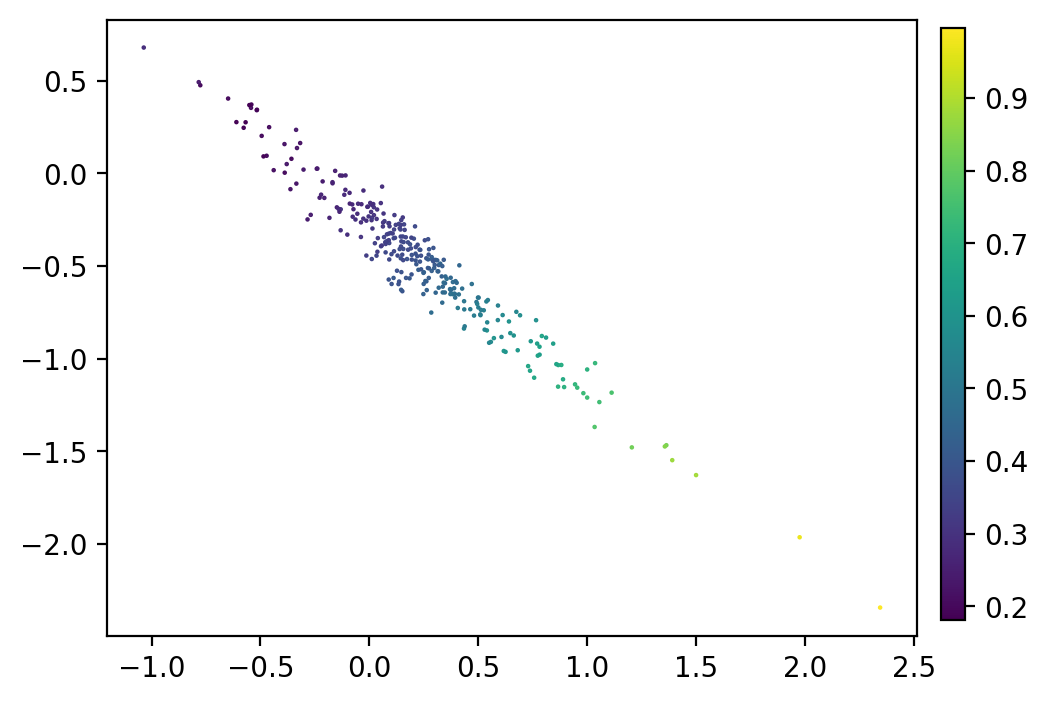

In [191]:
vae.eval()
x, y = train_dataset.train_x, train_dataset.train_y
with torch.no_grad():
    recon_batch, mu, logvar = vae(x)
    z = mu.cpu().numpy()
    y = y.cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 4))

im = ax.scatter(
    z[:, 0], z[:, 1], 
    c=y,
    cmap="viridis",
    # vmin=0.0, vmax=1.0,
    marker='o', s=0.4)
# ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)

fig.subplots_adjust(right=0.8)
plt.colorbar(im, fig.add_axes([0.82, 0.13, 0.02, 0.74]))
plt.show()

In [193]:
vae.eval()
rx, ry = np.arange(-3, 3, 0.25), np.arange(-3, 3, 0.25)
gx, gy = np.meshgrid(rx, ry)
z = np.c_[gx.ravel(), gy.ravel()]


with torch.no_grad():
    z = torch.from_numpy(z).float()
    x = vae.decode(z)

    y = torch.tensor([
        - eval_policy(
            env=env,
            policy=pol) for pol in x])  

    x = x.cpu().numpy()
    y = y.cpu().numpy()
    z = z.cpu().numpy()

gz = y.reshape(gx.shape)

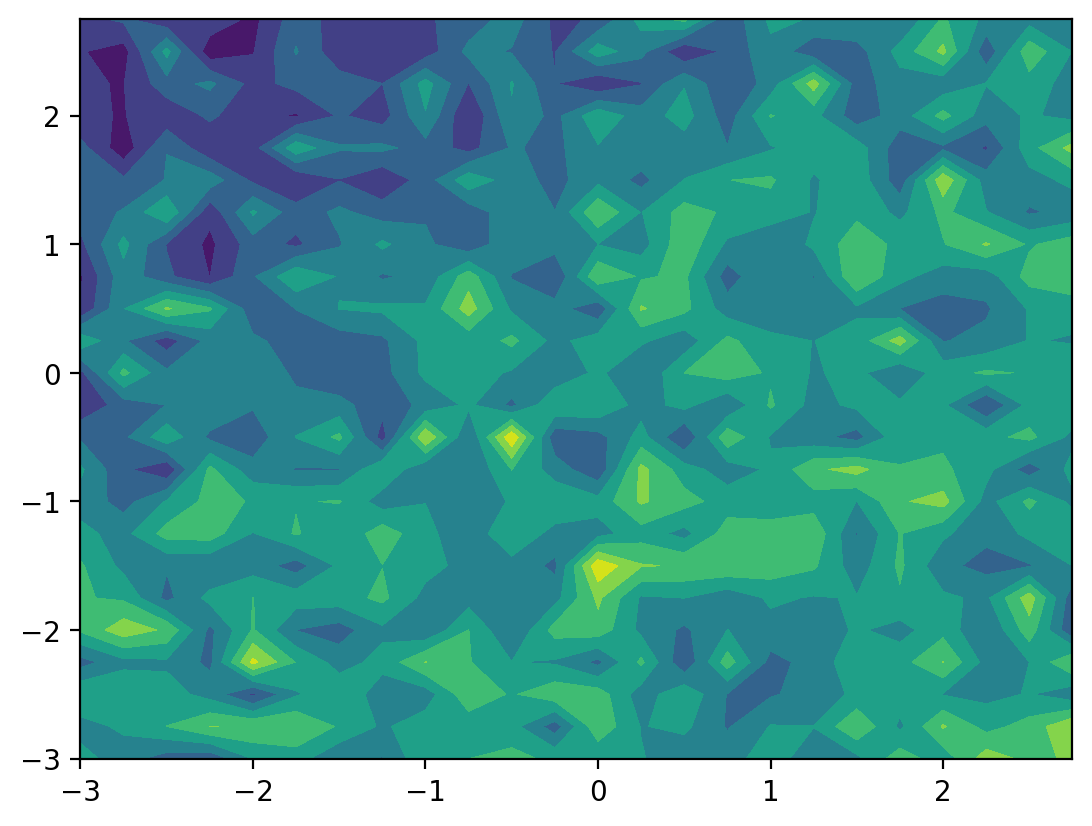

In [201]:
im = plt.contourf(gx, gy, gz, cmap='viridis')

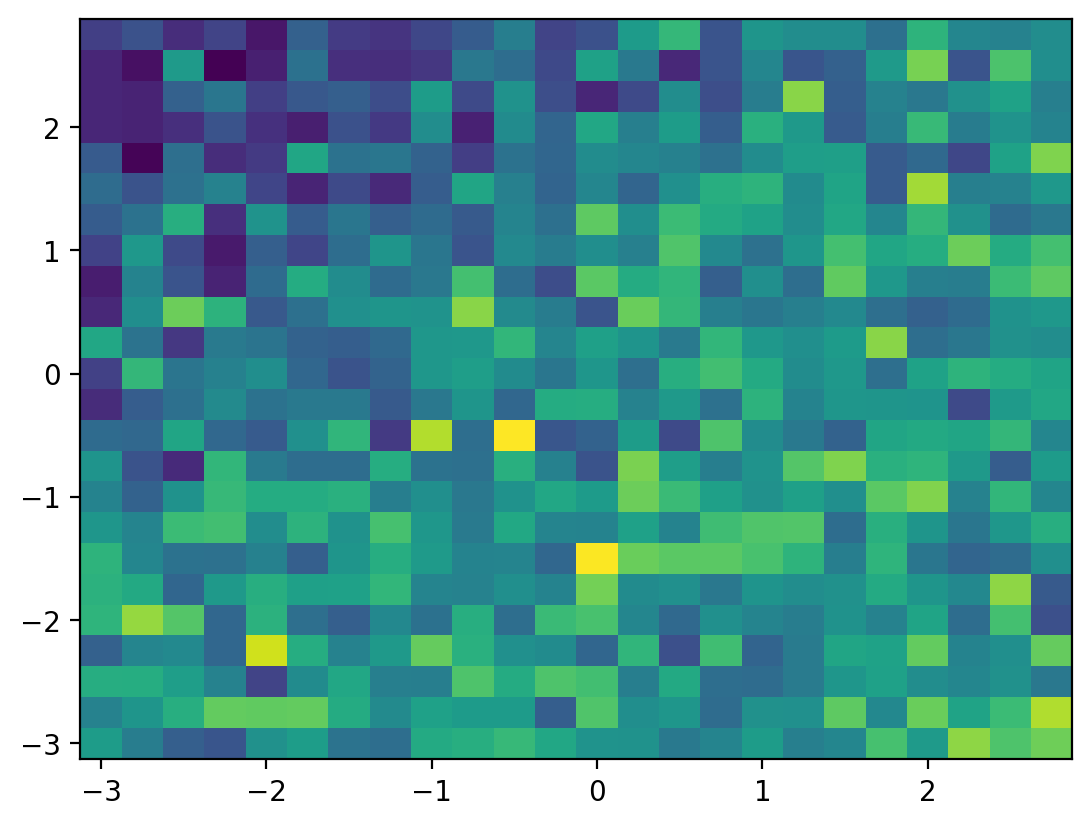

In [202]:
plt.pcolormesh(gx, gy, gz);

In [197]:
import pandas as pd

In [198]:
z, _ = vae.encode(train_dataset.train_x)
print(z.shape)
vae.decode(z).shape

torch.Size([300, 2])


torch.Size([300, 50])

In [200]:
dtype=torch.float

acq_opt__batch_size = 3
acq_opt__num_restarts = 10
acq_opt__raw_samples = 256

qmc_sampler__sample_shape = 2048
qmc_sampler__seed = 13537

n_batch = 10

n_sample_start = 10


best_observed = []
cand_observed = []
val_observed = []

# --------------------------------
# train_z = torch.rand(n_sample_start, size_z, device=device, dtype=dtype)

# with torch.no_grad():
#    train_x = vae.decode(train_z)
#    train_y = torch.tensor([
#        - eval_policy(
#            env=env,
#            policy=pol) for pol in train_x])  
best = torch.topk(train_dataset.train_y, k=n_sample_start).indices
train_x = train_dataset.train_x[best]
train_y = train_dataset.train_y[best]
with torch.no_grad():
    vae.eval()
    train_z, _ = vae.encode(train_dataset.train_x[best])
# ------------------------------


state_dict = None
# run N_BATCH rounds of BayesOpt after the initial random batch
with tqdm(total=n_batch) as pbar:
    for iteration in range(n_batch):

        # fit the GP model
        # normalize(train_h, bounds=bounds), 
        # standardize(train_obj) 
        model = SingleTaskGP(train_X=train_z, train_Y=train_y.unsqueeze(dim=1))
        # if state_dict is not None:
        #     model.load_state_dict(state_dict)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        mll.to(device)
        fit_gpytorch_mll(mll)

        # define the qNEI acquisition module using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(
            sample_shape=qmc_sampler__sample_shape,
            seed=qmc_sampler__seed
        )
        qEI = qExpectedImprovement(
            model=model, 
            sampler=qmc_sampler, 
            best_f=train_y.max())

        # optimize and get new observation
        # optimize
        bounds = torch.zeros((2, size_z))
        bounds[0, :] = - 4
        bounds[1, :] = 4
        candidates, _ = optimize_acqf(
            acq_function=qEI,
            bounds=bounds,
            q=acq_opt__batch_size,
            num_restarts=acq_opt__num_restarts,
            raw_samples=acq_opt__raw_samples,
        )

        # observe new values 
        with torch.no_grad():
            new_z = candidates.detach()
            new_x = vae.decode(new_z)
            new_y = torch.tensor([
                - eval_policy(
                    env=env,
                    policy=pol) for pol in new_x])  

        # update training points
        train_z = torch.cat((train_z, new_z))
        train_x = torch.cat((train_x, new_x))
        train_y = torch.cat((train_y, new_y))

        # update progress
        best_value = train_y.max().item()
        best_observed.append(best_value)
        cand_observed.append([cand.numpy().tolist() for cand in candidates])
        val_observed.append([val.item() for val in new_y])

        # state_dict = model.state_dict()
        
        pbar.update()
        pbar.set_postfix({"best": f"{best_value:.2f}"})

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
fig, ax = plt.subplots()
ax.plot(best_observed)

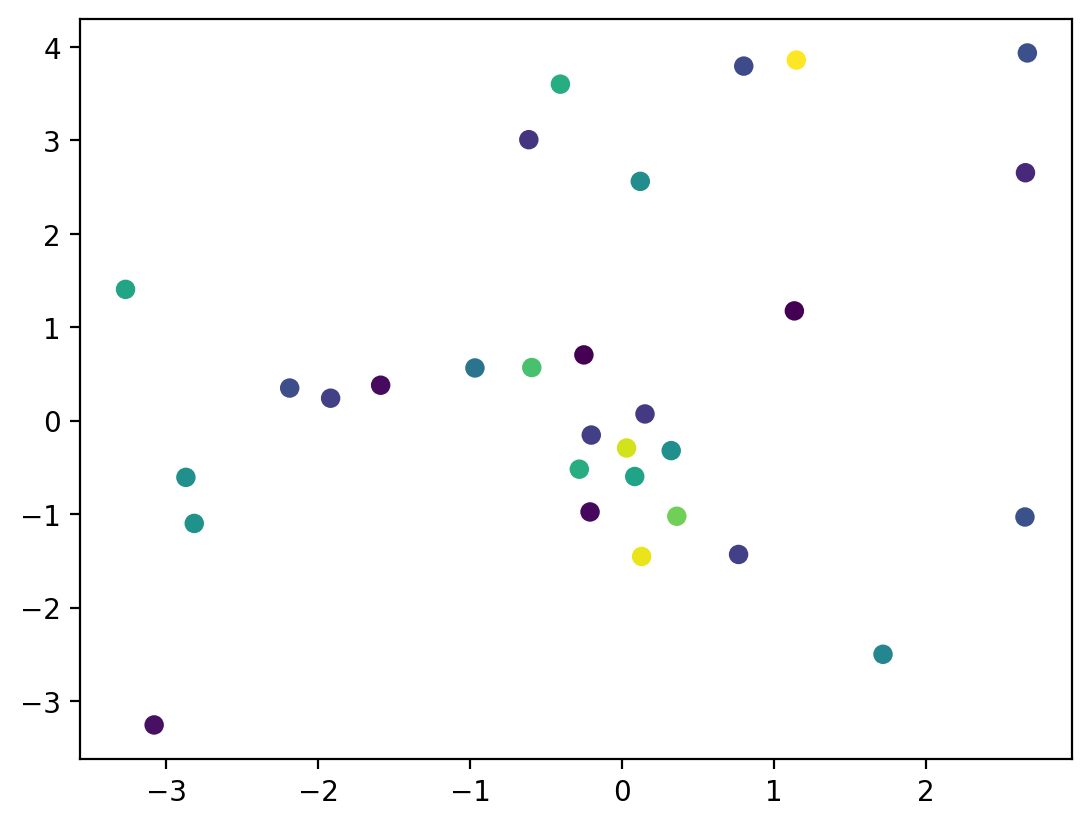

In [144]:
cand_observed = np.array(cand_observed)
val_observed = np.array(val_observed)
plt.scatter(x=cand_observed[:, :, 0], y=cand_observed[:, :, 1], c=val_observed,  cmap="viridis") 

In [ ]:
fig, ax = plt.subpolots()

In [137]:
np.zeros(3).tolist()

[0.0, 0.0, 0.0]

In [146]:
val_observed.max()

0.5862594842910767

## Same thing but with NN

In [153]:
class DecisionMaker(nn.Module):
    def __init__(self, init_value):
        super().__init__()
        self.param = nn.Parameter(init_value)


dm_init_value, _ = vae.encode(train_dataset.train_x[torch.argmax(train_dataset.train_y)])

dm = DecisionMaker(init_value=dm_init_value)
dm.to(device)
dm.train()

hist_y = []

epochs= 5000

optimizer = optim.Adam(dm.parameters(), lr=0.01)

with tqdm(total=epochs) as pbar:
    
    for epoch in range(epochs):
      
        optimizer.zero_grad()
        
        z = dm.param
        x = vae.decode(z)
        loss = eval_policy(env=env, policy=x, p=None).to(device)
        y = - loss
        
        loss.backward()
        optimizer.step()

        hist_y.append(y.detach().item())
        best_value = np.max(hist_y) 
        
        pbar.update()
        pbar.set_postfix(loss=f"{loss.item():.4f}", best=f"{best_value:.4f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 